<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AtariスペースインベーダのPPO による強化学習の実装

参考

- https://github.com/vpj/rl_samples
http://blog.varunajayasiri.com/ml/ppo_pytorch.html

ほぼそのままです。違いはクラウドログサービスを WandB に変更してあることと、そのままだと過学習のせいか得点が伸びずに戦略が固まってしまうようなので、εグリーディを pytorch だよりとは別に設定できるようにした点ぐらいです。

#### 他に参考にしたサイト

- [PythonでPPOを実装してみた](https://qiita.com/oki_uta_aiota/items/a15ba5de6ed3c1268ed3#%E5%85%A8%E4%BD%93%E3%81%AE%E3%82%B3%E3%83%BC%E3%83%89)

In [1]:
import random
import time
random.seed(time.time())

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))
devCPU = torch.device('cpu')

device(type='cuda', index=0)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 外部ライブラリの追加

In [3]:
!pip install pfrl > /dev/null
!pip install wandb > /dev/null
!pip install fastprogress > /dev/null
#!pip install gym[atari] > /dev/null

In [4]:
import multiprocessing
import multiprocessing.connection
from typing import Dict, List
from fastprogress.fastprogress import master_bar, progress_bar

import gym
from gym import ObservationWrapper
from gym.spaces import Box

import cv2
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.distributions import Categorical
from torch.nn import functional as F

from pfrl.wrappers.atari_wrappers import FrameStack,NoopResetEnv,MaxAndSkipEnv
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

# ラッパー定義

In [5]:
class myCrop(ObservationWrapper):
    def __init__(self, env, tmgn=0, bmgn=0,lmgn=0,rmgn=0,igcolors=[],bgcolor=[0,0,0]):
        super(myCrop, self).__init__(env)
        self.tmgn, self.bmgn = tmgn, bmgn
        self.lmgn, self.rmgn = lmgn, rmgn
        self.igcolors, self.bgcolors = igcolors, bgcolor
        self.observation_space = Box(low=0, high=255, shape=(84,84), dtype=np.uint8)
    def observation(self, obs):
        img_mask = np.zeros(obs.shape[:2],np.uint8)
        for color in self.igcolors:
            bgrLower = np.array(color)    
            bgrUpper = np.array(color)
            tmask = cv2.inRange(obs, bgrLower, bgrUpper) 
            img_mask = cv2.bitwise_or(img_mask,tmask)
        obs = cv2.bitwise_and(obs,obs,mask=255-img_mask) # 元画像とマスクを合成
        RIGHT=obs.shape[1]-self.rmgn
        BOTTOM=obs.shape[0]-self.bmgn
        obs = obs[self.tmgn:BOTTOM,self.lmgn:RIGHT]
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        observation = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)
        return observation

class myFrameStack(FrameStack):
    def __init__(self, env, k=8, deadloss=0,demo=False):
        super(myFrameStack, self).__init__(env, k=k, channel_order="chw")
        self.deadloss = deadloss
        self.lives = 0
        self.lsumrewards = 0
        self.localsteps = 0
        self.demo = demo
    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        self.lives = self.env.unwrapped.ale.lives()
        self.lsumrewards = 0
        self.localsteps = 0
        return  np.array([list(self.frames)])
    def step(self, action):
        ob, reward, done1, info = self.env.step(action)
        self.frames.append(ob)
        rewardalpha = reward
        episode_info = None
        # 残機数確認
        lives = self.env.unwrapped.ale.lives()
        self.localsteps += 1  
        self.lsumrewards += reward
        if self.demo:
            return np.array([list(self.frames)]),_,done1,info
        else: # if train mode
            if done1 or lives < self.lives: # １機死んだら終了とする
                done = True
                episode_info = {"reward": self.lsumrewards, "length": self.localsteps}
                if lives < self.lives:
                    rewardalpha = reward - self.deadloss # 機体を失うことのペナルティ
                self.reset()
            else:
                done = False
            return np.array([list(self.frames)]), rewardalpha, done, episode_info

def mkenv(envname,k=8,skip=2,tmgn=0,bmgn=0,lmgn=0,rmgn=0,igcolors=[],deadloss=0,noop_max=30, demo=False):
  env=gym.make(envname)
  if noop_max > 0:
      env = NoopResetEnv(env, noop_max=noop_max)
  if skip > 1:
      env = MaxAndSkipEnv(env, skip=skip)
  env=myCrop(env, tmgn=tmgn, bmgn=bmgn, lmgn=lmgn, rmgn=rmgn, igcolors=igcolors)
  env=myFrameStack(env,k=k,deadloss=deadloss,demo=demo)
  return env

# Game Environment の定義

In [6]:
import random
from datetime import datetime
random.seed(datetime.now())
DEFAULTSEED = random.randint(1, 10000)
def Game(seed=DEFAULTSEED,k=8,skip=2,deadloss=0,noop_max=30):
    ENV_NAME = 'SpaceInvadersNoFrameskip-v4'
    Tmgn=20
    Bmgn=12
    Lmgn=8
    Rmgn=8
    #NOCOLOR=[[162,134,56]]  # 背景と同一視するカラー
    NOCOLOR=[]

    env = mkenv(ENV_NAME,k,skip,Tmgn,Bmgn,Lmgn,Rmgn,NOCOLOR,deadloss=deadloss,noop_max=noop_max)
    env.seed(seed)
    return env

### 補足
**k** : 過去何フレーム分の画面をデータとするか  
**skip** : 何フレームおきにサンプリングするか  
**Tmgn,Bmgn,Lmgn,Rmgn** カットする余白量  
**NOCOLOR** 黒に置き換える色をRGB指定。複数指定可能  
上の設定はインベーダ決め打ち

## 動作確認

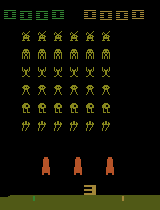

(210, 160, 3)

(7, 84, 84)

0

120

numpy.uint8

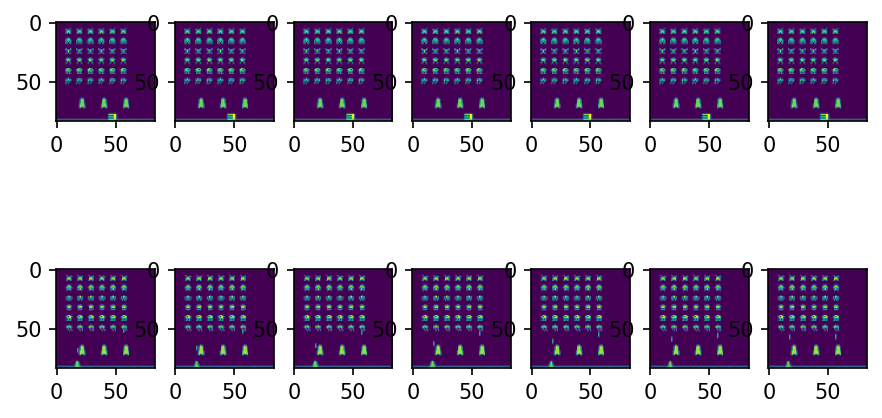

In [7]:
import random
from datetime import datetime
DEFAULTSEED = random.seed(datetime.now())

# 原画像が表示できるかテスト
game = Game(DEFAULTSEED,7)
orgimg = game.render(mode='rgb_array')
display(Image.fromarray(orgimg))
display(orgimg.shape)

# リセット画像の確認
plt.figure(figsize=(8,4),dpi=150)
imgs = game.reset()
imgs = imgs[0]
for i,img in enumerate(imgs):
    plt.subplot(2,8,i+1)
    plt.imshow(img)
# ステップ画像の確認
for _ in range(60):
  imgs,r,d,i= game.step(game.action_space.sample()) 
imgs = imgs[0]
for i,img in enumerate(imgs):
    plt.subplot(2,8,i+9)
    plt.imshow(img)
    
# Check types
display(imgs.shape,imgs[0,0,0],imgs[0,40,40],type(imgs[0,0,0]))

# PPO用ニューラルネットのモデル定義

In [8]:
class Model(nn.Module):

    def __init__(self,nframes=8):
        super().__init__()

        # 4x84x84 → 32x20x20 
        self.conv1 = nn.Conv2d(in_channels=nframes, out_channels=64, kernel_size=8, stride=4)
        # 32x20x20 →64x9x9
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2)
        # 64x9x9 → 64x7x7 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        # 64x7x7 → 512 
        self.lin = nn.Linear(in_features=7 * 7 * 64, out_features=256)
        # 512 → 4 actions 0-1 （行動決定）
        self.pi_logits = nn.Linear(in_features=256, out_features=4)
        # 行動価値
        self.value = nn.Linear(in_features=256, out_features=1)

    def forward(self, obs: torch.Tensor):
        h = F.relu(self.conv1(obs))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = h.reshape((-1, 7 * 7 * 64))

        h = F.relu(self.lin(h))

        pi = Categorical(logits=self.pi_logits(h))
        value = self.value(h).reshape(-1)

        return pi, value

In [9]:
model = Model(16)
model.to(device)
game = Game(0,16)
obs = game.reset()
pi,v = model.forward(torch.tensor(obs,dtype=torch.float32,device=device)/255)
a0 = pi.sample() # 方策関数によりアクションを決定
a = a0[0] # アクション番号の数値化
b = pi.log_prob(a0) # 

display(obs.shape) # 画面データのシェイプを表示
display(a0)
display(a) # 選ばれたアクション番号を表示
display(b) # 
display(v.detach()) # 状態価値を表示
display(model) # モデルを表示

(1, 16, 84, 84)

tensor([1], device='cuda:0')

tensor(1, device='cuda:0')

tensor([-1.4152], device='cuda:0', grad_fn=<SqueezeBackward1>)

tensor([0.0428], device='cuda:0')

Model(
  (conv1): Conv2d(16, 64, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (lin): Linear(in_features=3136, out_features=256, bias=True)
  (pi_logits): Linear(in_features=256, out_features=4, bias=True)
  (value): Linear(in_features=256, out_features=1, bias=True)
)

# Multiprocessing Playloop
# 学習のメインプログラム

In [25]:
def playloop(agent: multiprocessing.connection.Connection,seed:int,k=8,skip=2,deadloss=0,noop_max=30):

    # create game
    game = Game(seed=seed, k=k,skip=skip,deadloss=deadloss,noop_max=noop_max)
    # AI player 
    while True:
        cmd, action = agent.recv()
        if cmd == "step":
            agent.send(game.step(action))
        elif cmd == "reset":
            agent.send(game.reset())
        elif cmd == "close":
            agent.close()
            break
        else:
            raise NotImplementedError

class CoPlayer:
    def __init__(self, seed, k=8,skip=2,deadloss=0,noop_max=30):
        self.child, parent = multiprocessing.Pipe()
        self.process = multiprocessing.Process(target=playloop, args=(parent, seed, k,skip,deadloss,noop_max))
        self.process.start()

### パイプ動作確認

In [26]:
cop2 = CoPlayer(0,8)
cop2.child.send(("reset",None))
a = cop2.child.recv()
cop2.child.send(("step",1))
a2,b,c,d = cop2.child.recv()
cop2.child.send(("close",None))
a.shape,a2.shape,b,c,d

((1, 8, 84, 84), (1, 8, 84, 84), 0.0, False, None)

### ログフォルダの設定

In [27]:
import os
SAVEFOLDER = '/content/drive/MyDrive/M/ppo'
os.makedirs(SAVEFOLDER,exist_ok=True)

In [28]:
# from tqdm.notebook import tqdm
NCYCLES = 2000 # 学習サイクル数　（データ収集→学習　が1サイクル）
ENDGREEDYCYCLES = 1000 # 1000
GreedyEPS_START = 0.2 # 0.3 
GreedyEPS_END = 0.05 # 0.1
# Hyper Parameters
GAMMA = 0.9
LAMDA = 0.95
EPOCHS =  4 # サンプル１セットを何度学習プロセスに通すか
NPLAYERS = 8 # 並列実行する数game
NBATCHES = 256 # １度に処理するデータ数
NDIVIDE = 4 # バッチの分割数
SEEDZero = random.randint(1,10000)
LearningRate = 0.001
NFRAMES = 16
W_VFLOSS = 0.5 # loss におけるvfloss の重み
W_BONUS = 0.01 # loss における entropy bonus の重み
CLIPRANGE = 0.2 # ## Run it

In [29]:
class Main:

    def __init__(self,seed=SEEDZero,k=NFRAMES,skip=2,deadloss=0,noop_max=0):

        self.k = k
        self.lifes = 0 # 失った機体数 lost lifes
        self.cycles = 0 # バッチ回数

        self.progress = progress = 0
        
        # 1サイクルに必要なサンプル数
        self.batch_size = NPLAYERS * NBATCHES
        # ミニバッチのサイズ
        self.mini_batch_size = self.batch_size // NDIVIDE

        # 初期化
        # CoPlayerの生成
        self.coplayers = [CoPlayer(seed + i, k,deadloss,) for i in range(NPLAYERS)]

        # 観測情報の初期化　この部分を float や tensor にすると k が４に制限されてしまうので int で
        self.obs = np.zeros((NPLAYERS, k, 84, 84), dtype=np.uint8)
        for player in self.coplayers:
            player.child.send(("reset", None))
        for i, player in enumerate(self.coplayers):
            self.obs[i] = player.child.recv()

        # model for sampling
        self.model = model = Model(k).to(device)
        resume = True # 学習済み重みを読み込むかどうか
        if resume:
          self.model.load_state_dict(torch.load(SAVEFOLDER+"/model" ))

        # optimizer
        lr = LearningRate
        optimizers = {}
        # optimizers['SGD'] = optim.SGD(model.parameters(), lr)
        # optimizers['Adagrad'] = optim.Adagrad(model.parameters(), lr)
        # optimizers['RMSprop'] = optim.RMSprop(model.parameters(), lr)
        # optimizers['Adadelta'] = optim.Adadelta(model.parameters(), lr)
        # optimizers['Adam'] = optim.Adam(model.parameters(), lr)
        optimizers['AdamW'] = optim.AdamW(model.parameters(), lr)
        self.optimizer = optimizers['AdamW']

    @staticmethod
    def _toTT(obs: np.ndarray) -> torch.Tensor:
        return torch.tensor(obs, dtype=torch.float32, device=device) / 255.0

    @staticmethod
    def _normalize(adv: torch.Tensor):
        return (adv - adv.mean()) / (adv.std() + 1e-8)

    def sample(self) -> (Dict[str, torch.Tensor], List):
        # 学習データの記憶域確保
        rewards = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        actions = np.zeros((NPLAYERS, NBATCHES), dtype=np.int32)
        done = np.zeros((NPLAYERS, NBATCHES), dtype=np.bool)
        obs = np.zeros((NPLAYERS, NBATCHES, self.k, 84, 84), dtype=np.float32)
        log_pis = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        values = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        
        # 画像データの初期化
        for t in progress_bar(range(NBATCHES), parent=self.mpbar):
            with torch.no_grad(): # 傾きを固定して実行
                obs[:, t] = self.obs
                pi, v = self.model(self._toTT(self.obs))
                values[:, t] = v.cpu().numpy()
                a0 = pi.sample()
                a =a0.cpu().numpy()
                # epsiron greedy action selection
                if self.progress >= ENDGREEDYCYCLES:
                    g_eps = GreedyEPS_END
                else:
                    g_eps = GreedyEPS_START  + self.progress * (GreedyEPS_END - GreedyEPS_START) 
                for i in range(NPLAYERS):
                    if torch.rand(1) <= g_eps: 
                        a[i] = np.random.randint(4)
                actions[:, t] = a
                log_pis[:, t] = pi.log_prob(a0).cpu().numpy()
                
            for w, player in enumerate(self.coplayers):
                player.child.send(("step", actions[w, t]))
 
            for w, player in enumerate(self.coplayers):
                self.obs[w], rewards[w, t], done[w, t], info  =  player.child.recv()

                if info :
                    self.lifes += 1
                    wandb.log({'reward':info['reward'],'lengt':info['length']})
                    wandb.log({'lifes':self.lifes,'cycles':self.cycles})
             
        # calculate advantages
        advantages = self._calc_advantages(done, rewards, values)
        samples = {
            'obs': obs,
            'actions': actions,
            'values': values,
            'log_pis': log_pis,
            'advantages': advantages
        }

        samples_flat = {}
        for k, v in samples.items():
            v = v.reshape(v.shape[0] * v.shape[1], *v.shape[2:])
            if k == 'obs':
                samples_flat[k] = self._toTT(v)
            else:
                samples_flat[k] = torch.tensor(v, device=device)
        return samples_flat

    def _calc_advantages(self, done: np.ndarray, rewards: np.ndarray, values: torch.Tensor) -> np.ndarray:
        advantages = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        last_advantage = 0
        _, last_value = self.model(self._toTT(self.obs))
        last_value = last_value.cpu().data.numpy()

        for t in reversed(range(NBATCHES)):
            mask = 1 - done[:, t]
            last_value = last_value * mask
            last_advantage = last_advantage * mask
            delta = rewards[:, t] + GAMMA * last_value - values[:, t]
            last_advantage = delta + GAMMA * LAMDA * last_advantage
            advantages[:, t] = last_advantage
            last_value = values[:, t]

        return advantages
    
    # 1サイクルの学習
    def train(self, samples: Dict[str, torch.Tensor], learning_rate: float, clip_range: float):

        for _ in range(EPOCHS):
            # 並べ替え用の数列
            indexes = torch.randperm(self.batch_size)

            # ミニバッチ単位で処理
            for start in range(0, self.batch_size, self.mini_batch_size):
                # get mini batch
                end = start + self.mini_batch_size
                mini_batch_indexes = indexes[start: end]
                mini_batch = {}
                for k, v in samples.items():
                    mini_batch[k] = v[mini_batch_indexes]

                # train
                loss = self._calc_loss(clip_range=clip_range,
                                       samples=mini_batch)

                # compute gradients
                for pg in self.optimizer.param_groups:
                    pg['lr'] = learning_rate
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
                self.optimizer.step()

    def _calc_loss(self, samples: Dict[str, torch.Tensor], clip_range: float) -> torch.Tensor:
        sampled_return = samples['values'] + samples['advantages']
        sampled_normalized_advantage = self._normalize(samples['advantages'])
        pi, value = self.model(samples['obs'])

        # #### Policy
        log_pi = pi.log_prob(samples['actions'])

        ratio = torch.exp(log_pi - samples['log_pis'])

        clipped_ratio = ratio.clamp(min=1.0 - clip_range,
                                    max=1.0 + clip_range)
        policy_reward = torch.min(ratio * sampled_normalized_advantage,
                                  clipped_ratio * sampled_normalized_advantage)
        policy_reward = policy_reward.mean()

        # #### Entropy Bonus
        entropy_bonus = pi.entropy()
        entropy_bonus = entropy_bonus.mean()

        # #### Value
        clipped_value = samples['values'] + (value - samples['values']).clamp(min=-clip_range,
                                                                              max=clip_range)
        vf_loss = torch.max((value - sampled_return) ** 2, (clipped_value - sampled_return) ** 2)
        vf_loss = 0.5 * vf_loss.mean()
        loss = -(policy_reward - W_VFLOSS* vf_loss + W_BONUS  * entropy_bonus)

        # for monitoring
        approx_kl_divergence = .5 * ((samples['log_pis'] - log_pi) ** 2).mean()
        clip_fraction = (abs((ratio - 1.0)) > clip_range).to(torch.float).mean()
        
        wandb.log({'policy_reward': policy_reward,
                     'vf_loss': vf_loss,
                     'entropy_bonus': entropy_bonus,
                     'kl_div': approx_kl_divergence,
                     'clip_fraction': clip_fraction})        
        return loss

    def run_training_loop(self):

        ### Run training loop
        self.mpbar = master_bar(range(NCYCLES))
        for cycle in self.mpbar:
            self.cycles = cycle 
            self.progress = progress = cycle / NCYCLES

            # decreasing `learning_rate` and `clip_range` 
            learning_rate = LearningRate * (1 - progress)
            clip_range = CLIPRANGE * (1 - progress)
            samples = self.sample()
            # train the model
            self.train(samples, learning_rate, clip_range)

            # write summary info to the writer, and log to the screen
            if (cycle + 1) % 10 == 0:
                torch.save(self.model.state_dict(),SAVEFOLDER+"/model" )
            if (cycle + 1) % 250 == 0:
                torch.save(self.model.state_dict(),SAVEFOLDER+'/model{}'.format(cycle+1))
        torch.save(self.model.state_dict(),SAVEFOLDER+"/model" )

    def destroy(self):

        for player in self.coplayers:
            player.child.send(("close", None))

## W and B


In [30]:
# Inside my model training code
import wandb
PROJECTNAME='ppo'
wandb.init(project=PROJECTNAME)

wandb: Currently logged in as: aquapathos (use `wandb login --relogin` to force relogin)


In [ ]:
if __name__ == "__main__":
    m = Main(SEEDZero,k=NFRAMES,skip=2,deadloss=10,noop_max=15)
    m.run_training_loop()
    m.destroy()

In [ ]:
# torch.save(model.state_dict(),'ppomodel')
# model.load_state_dict(torch.load('ppomodel'))
# torch.save(model.state_dict(),'ppomodel{}'.format(100))

# Demoモード

Colab では表示できません

In [ ]:
random.seed(datetime.now())
DEFAULTSEED = random.randint(1, 10000)
import time

model = Model(NFRAMES).to(device)
model.load_state_dict(torch.load(SAVEFOLDER+"/model" ))
game = Game(seed=DEFAULTSEED, k=NFRAMES,skip=1,deadloss=0,noop_max=0,demo=True)

def _toTT(obs: np.ndarray) -> torch.Tensor:
    return torch.tensor(obs, dtype=torch.float32, device=device) / 255.0    

for i in range(10):
    print(i,end='')
    observation = game.reset()  
    while True:
        time.sleep(0.02)
        game.render()
        pi, v = model(_toTT(observation))
        action = pi.sample().cpu().numpy()[0] # 方策関数によりアクションを決定
        observation, reward, done, info = game.step(action) 
        if done: 
          break;
        
game.close()